In [3]:
import numpy as np
import pandas as pd

# Dataset

Here we have spa-SIM data of labeled centromere-related proteins.  We are particularly looking at the spacing between peaks along the line connecting them.  The chromosome flows through the middle, and we want to know if our proteins of interest (probe) is shifted into the chrosome or away from the chromosome relative to an anchor protein (CenpA).  CenpA (in green) is present in all of our images, an example of a probe SGO1 (in magenta) is below.

For each experiment we have fit the position of the peaks relative to the center of the line for both CenpA (in Data/CenpA.csv) and the probe (Data/Probes.csv)

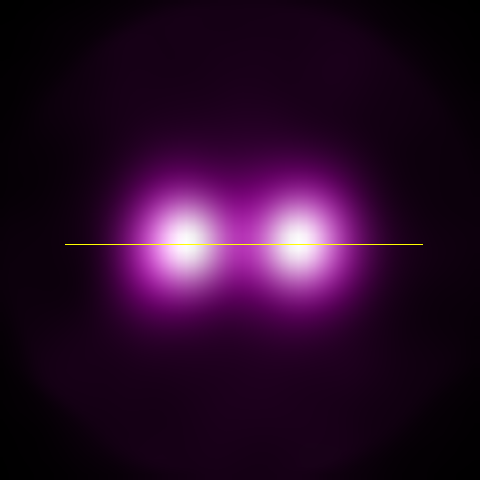

In [67]:
# DO NOT DELETE
from IPython.display import Image
Image(filename='Data/CenpA.png', width=600)

# Part 1:  Load and explore

### Question 1:  Load the two datasets into separate dataframes

In [53]:
probe_df = pd.read_csv('Data/Probes.csv')
cenpA_df = pd.read_csv('Data/CenpA.csv')

### Question 2:  Convert the Peak1 and Peak2 values to nanometers

Currently Peak1 and Peak2 in both files are in terms of microns, but we will get tired of looking at decimal points, so convert all values to nanometers.

In [54]:
probe_df['Peak1'] = probe_df['Peak1'] * 1000
cenpA_df['Peak1'] = cenpA_df['Peak1'] * 1000


probe_df['Peak2'] = probe_df['Peak2'] * 1000
cenpA_df['Peak2'] = cenpA_df['Peak2'] * 1000


### Question 3:  For both dataframes, calculate a 'pk2pk' that takes the difference between 'Peak2' and 'Peak1'

In [68]:
probe_df['pk2pk'] = probe_df['Peak2'] - probe_df['Peak1']
cenpA_df['pk2pk'] = cenpA_df['Peak2'] - cenpA_df['Peak1']

### Question 4:  Use groupby() and agg() to find the average, standard deviation, min, and max of the pk2pk values for both dataframes

In [69]:
probe_agged = probe_df.groupby(['Probe']).agg(mean_pk2pk=('pk2pk', 'mean'), std_pk2pk=('pk2pk', 'std'), min_pk2pk=('pk2pk', 'min'), max_pk2pk=('pk2pk', 'max')).reset_index()
probe_agged

,Probe,mean_pk2pk,std_pk2pk,min_pk2pk,max_pk2pk
0,Caph,595.8,49.165028,520.0,644.0
1,Caph2,575.6,35.189487,530.0,617.0
2,SGOL1,525.5,83.004518,467.0,620.5


In [70]:
cenpA_agged = cenpA_df.groupby(['Probe']).agg(mean_pk2pk=('pk2pk', 'mean'), std_pk2pk=('pk2pk', 'std'), min_pk2pk=('pk2pk', 'min'), max_pk2pk=('pk2pk', 'max')).reset_index()
cenpA_agged

,Probe,mean_pk2pk,std_pk2pk,min_pk2pk,max_pk2pk
0,CenpA,564.153846,62.995828,435.0,632.0


Note the HUGE discrepancy across experiment runs!  This is a result of the variability in the process of preparing chromosome spreads.  If our probe pk2pk is different from our CenpA pk2pk, we want to get a meaningful distance, but it won't be a consistent metric unless we normalize our CenpA pk2pk distances to a standard.

# Part 2:  Merge and normalize

### Question 5:  Merge the two dataframes into a single one (df), and drop everything other than Date, Probe, pk2pk_probe, pk2pk_cenpA

In [73]:
df = probe_df.merge(cenpA_df, on='Date', suffixes=('_probe', '_cenpA'))
df = df.loc[:, ['Date', 'Probe_probe', 'pk2pk_probe', 'pk2pk_cenpA']]
df

,Date,Probe_probe,pk2pk_probe,pk2pk_cenpA
0,20250205,Caph,576.0,569.0
1,20250206,Caph,520.0,530.0
2,20250421A,Caph,644.0,632.0
3,20250421B,Caph,613.0,594.0
4,20250421C,Caph,626.0,630.0
5,20250203,Caph2,530.0,551.0
6,20250204,Caph2,550.0,570.0
7,20250422A,Caph2,617.0,627.0
8,20250422B,Caph2,596.0,606.0
9,20250422C,Caph2,585.0,602.0


### Question 6:  Use .groupby() and .transform() to add a new column to df that gives the mean pk2pk_cenpA for that Probe

In [74]:
df['mean_pk2pk_cenpA'] = df.groupby('Probe_probe')['pk2pk_cenpA'].transform('mean')
df

,Date,Probe_probe,pk2pk_probe,pk2pk_cenpA,mean_pk2pk_cenpA
0,20250205,Caph,576.0,569.0,591.000000
1,20250206,Caph,520.0,530.0,591.000000
2,20250421A,Caph,644.0,632.0,591.000000
3,20250421B,Caph,613.0,594.0,591.000000
4,20250421C,Caph,626.0,630.0,591.000000
5,20250203,Caph2,530.0,551.0,591.200000
6,20250204,Caph2,550.0,570.0,591.200000
7,20250422A,Caph2,617.0,627.0,591.200000
8,20250422B,Caph2,596.0,606.0,591.200000
9,20250422C,Caph2,585.0,602.0,591.200000


### Question 7:  Calculate a normalization factor based on mean_pk2pk_cenpA and pk2pk_cenpA, and create a new column that applies that correction to pk2pk_probe

In [75]:
df['correction_factor'] = df['mean_pk2pk_cenpA'] / df['pk2pk_cenpA']
df['pk2pk_probe_corrected'] = df['pk2pk_probe'] * df['correction_factor']
df

,Date,Probe_probe,pk2pk_probe,pk2pk_cenpA,mean_pk2pk_cenpA,correction_factor,pk2pk_probe_corrected
0,20250205,Caph,576.0,569.0,591.000000,1.038664,598.270650
1,20250206,Caph,520.0,530.0,591.000000,1.115094,579.849057
2,20250421A,Caph,644.0,632.0,591.000000,0.935127,602.221519
3,20250421B,Caph,613.0,594.0,591.000000,0.994949,609.904040
4,20250421C,Caph,626.0,630.0,591.000000,0.938095,587.247619
5,20250203,Caph2,530.0,551.0,591.200000,1.072958,568.667877
6,20250204,Caph2,550.0,570.0,591.200000,1.037193,570.456140
7,20250422A,Caph2,617.0,627.0,591.200000,0.942903,581.770973
8,20250422B,Caph2,596.0,606.0,591.200000,0.975578,581.444224
9,20250422C,Caph2,585.0,602.0,591.200000,0.982060,574.504983


### Question 8:  Calculate the gap between mean_pk2pk_cenpA and your corrected pk2pk_probe value and save to 'corrected_gap', use groupby() and .agg() to calculate the corrected_gap's mean and std for each Probe

In [76]:
df['probe_gap'] = df['mean_pk2pk_cenpA'] - df['pk2pk_probe_corrected']
agged = df.groupby(['Probe_probe']).agg(mean_probe_gap=('probe_gap', 'mean'), std_probe_gap=('probe_gap', 'std')).reset_index()
agged

,Probe_probe,mean_probe_gap,std_probe_gap
0,Caph,-4.498577,11.972735
1,Caph2,15.831160,6.076211
2,SGOL1,-49.352013,26.510936
